# OpenAI - Request for Research 2.0 (https://blog.openai.com/requests-for-research-2/)

## Warmup

   Train an LSTM to solve the XOR problem: that is, given a sequence of bits, determine its parity. The LSTM should consume the sequence, one bit at a time, and then output the correct answer at the sequence’s end. Test the two approaches below:

 *  Generate a dataset of random 100,000 binary strings of length 50. Train the LSTM; what performance do you get?

 *  Generate a dataset of random 100,000 binary strings, where the length of each string is independently and randomly chosen between 1 and 50. Train the LSTM. Does it succeed? What explains the difference?


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import inspect
import torch.utils.data as data_utils
import pdb
import random
import utils
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch.nn.utils.rnn as rnn_utils
torch.manual_seed(0)  

## Generating Bits String

In [18]:
def generate_binary(length=1, num=1, variable=False):
    inputs = []
    targets = []
    for i in range(0, num):
        sum = 0
        input = []
        target = []
        for j in range(0, length):
            temp = random.randint(0, 1)
            sum += temp
            current_input = np.zeros(2)
            current_input[temp] = 1
            input.append(current_input)
            target.append(sum % 2)
        inputs.append(input)
        targets.append(target)
    inputs = torch.Tensor(inputs)
    targets = torch.Tensor(targets).unsqueeze(2)
    return inputs, targets
    
    
def collate_generate(batchsize=2, is_variable_length=False):
    def pad_collate(batch):
        data = [item[0] for item in batch]
        target = [item[1] for item in batch]
        length = len(data[0])
        
        lengths_vector = [random.randint(1,length) if is_variable_length else length for i in range(0, batchsize)]
        lengths_vector.sort(reverse=True)
        
        data = rnn_utils.pack_padded_sequence(torch.stack(data), lengths_vector, batch_first=True)
        target = rnn_utils.pack_padded_sequence(torch.stack(target), lengths_vector, batch_first=True)
        return [data, target]
    return pad_collate

'''
i, t = generate_binary(length=4, num=20,variable=True)
print (rnn_utils.pad_packed_sequence(i, batch_first=True)[0])
print (rnn_utils.pad_packed_sequence(i, batch_first=True)[1])
print (rnn_utils.pad_packed_sequence(t, batch_first=True)[0])
print (rnn_utils.pad_packed_sequence(t, batch_first=True)[1])
'''


'\ni, t = generate_binary(length=4, num=20,variable=True)\nprint (rnn_utils.pad_packed_sequence(i, batch_first=True)[0])\nprint (rnn_utils.pad_packed_sequence(i, batch_first=True)[1])\nprint (rnn_utils.pad_packed_sequence(t, batch_first=True)[0])\nprint (rnn_utils.pad_packed_sequence(t, batch_first=True)[1])\n'

# Single Layer LSTM Model

In [3]:
class LSTMModel(nn.Module):
    def __init__(self, feature_size, hidden_size):
        super(LSTMModel, self).__init__()
        self.feature_size = feature_size
        self.hidden_size = hidden_size
        
        self.rnn = nn.LSTM(
            input_size=feature_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True)
        self.h2o = nn.Linear(hidden_size, 1)
        self.sig = nn.Sigmoid()

    def unpacked(self, hidden):
        if isinstance(hidden, torch.nn.utils.rnn.PackedSequence):
            hidden, lengths_vector = rnn_utils.pad_packed_sequence(hidden, batch_first=True)
        return hidden
        
    def forward(self, inputs):
        h, h_and_c = self.rnn(inputs)
        h = self.unpacked(h)
        outputs = self.h2o(h)
        return outputs, self.sig(outputs)
    
    
    def forward(self, inputs, hiddens):
        h, h_and_c = self.rnn(inputs, hiddens)
        h = self.unpacked(h)
        outputs = self.h2o(h)
        return outputs, self.sig(outputs)
    

    def initRandomHidden(self, batch_size=1):
        h = torch.zeros(1, batch_size, self.hidden_size)
        c = torch.zeros(1, batch_size, self.hidden_size)
        return [h, c]

# Training with fixed length 50
 *  Generate a dataset of random 100,000 binary strings of length 50. Train the LSTM; what performance do you get?


* batch size 20
* Vanilla SGD with learning rate 1
* Cross Entropy Loss
* Achieve 100 % with 2 hidden units after ~2 epochs

In [23]:
print_every = 300
epochs = 6
num_observation = 100000
num_test_observation = 10000

length = 50
hidden_size = 2
batch_size = 20

model = LSTMModel(2, hidden_size)
criterion = nn.BCEWithLogitsLoss()

def evaluate(model, num_samples=num_test_observation, is_variable_length=False):
    accuracy = 0
    inputs, targets = generate_binary(length=length, num=num_samples)
    dataset = torch.utils.data.TensorDataset(inputs, targets)
    
    
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=1,
        drop_last=True,
        collate_fn=collate_generate(batchsize=batch_size, is_variable_length=is_variable_length),
        pin_memory=True)

    
    for batch_idx, data in enumerate(dataloader, 1):
        hiddens = model.initRandomHidden(batch_size=batch_size)
        input, targets = data
        _, predicts = model(input, hiddens)

        # unpack targets PackedSequence to get  variable length vector
        targets, lengths_vector = rnn_utils.pad_packed_sequence(targets, batch_first=True)
    
        # we only care the final output of each string which is at index i-1 for i in lengths_vector
        for idx_in_batch, idx_in_sequence in enumerate(lengths_vector.tolist(), 0):
            #pdb.set_trace()
            accuracy += ((predicts[idx_in_batch, idx_in_sequence-1] > 0.5).numpy() ==  targets[idx_in_batch, idx_in_sequence-1].numpy())
        
    print (accuracy[0] / num_samples * 100, "%")

'''
Training
'''
inputs, targets = generate_binary(length=length, num=num_observation)
dataset = torch.utils.data.TensorDataset(inputs, targets)


for i in range(0, 1):
    lr = 1
    losses = []
    dataloader = torch.utils.data.DataLoader(
                    dataset,
                    batch_size=batch_size,
                    shuffle=True,
                    num_workers=1,
                    drop_last=True,
                    collate_fn=collate_generate(batchsize=batch_size,  is_variable_length=False),
                    pin_memory=True)

    print ("learning rate {}, batch size {}".format(lr, batch_size))
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    for i in range(1, epochs+1):    
        running_loss = 0
        for batch_idx, data in enumerate(dataloader, 1):
            hiddens = model.initRandomHidden(batch_size=batch_size)
            
            optimizer.zero_grad()
            input, targets = data
            
            outputs, _ = model(input, hiddens)
            
            # unpack targets PackedSequence to get  variable length vector
            _, lengths_vector = rnn_utils.pad_packed_sequence(targets, batch_first=True)
    
            # use pack_padded_sequence function to flatten output according to variable length vector
            outputs = rnn_utils.pack_padded_sequence(outputs, lengths_vector, batch_first=True)
    
            
            loss = criterion(outputs.data, targets.data)
            losses.append(loss)
            running_loss += loss
            
            loss.backward()
            optimizer.step()
            
            
            if batch_idx % print_every == 0:
                print ("epoch {}, batch {}, loss {}".format(i, batch_idx, running_loss / print_every))
                if running_loss / print_every < 1e-2:
                    break
                running_loss = 0
        print ("Accuracy: ")
        evaluate(model, num_samples=100, is_variable_length=True)
        
print ('#' * 100, '\nTestSet Accuracy:')
evaluate(model, num_samples=num_test_observation, is_variable_length=True)

learning rate 1, batch size 20
epoch 1, batch 300, loss 0.6936256885528564
epoch 1, batch 600, loss 0.6932411789894104
epoch 1, batch 900, loss 0.693221390247345
epoch 1, batch 1200, loss 0.693185031414032
epoch 1, batch 1500, loss 0.6930814981460571
epoch 1, batch 1800, loss 0.6930596828460693
epoch 1, batch 2100, loss 0.6929906010627747
epoch 1, batch 2400, loss 0.6930245161056519
epoch 1, batch 2700, loss 0.6930193305015564
epoch 1, batch 3000, loss 0.6930099725723267
epoch 1, batch 3300, loss 0.6929218769073486
epoch 1, batch 3600, loss 0.6928685307502747
epoch 1, batch 3900, loss 0.6927436590194702
epoch 1, batch 4200, loss 0.6927247047424316
epoch 1, batch 4500, loss 0.6926406025886536
epoch 1, batch 4800, loss 0.6924952864646912
Accuracy: 
57.99999999999999 %
epoch 2, batch 300, loss 0.6923717260360718
epoch 2, batch 600, loss 0.69215989112854
epoch 2, batch 900, loss 0.6919844746589661
epoch 2, batch 1200, loss 0.6917996406555176
epoch 2, batch 1500, loss 0.6915663480758667
epo

In [20]:
train_fixed_test_fixed_loss = losses

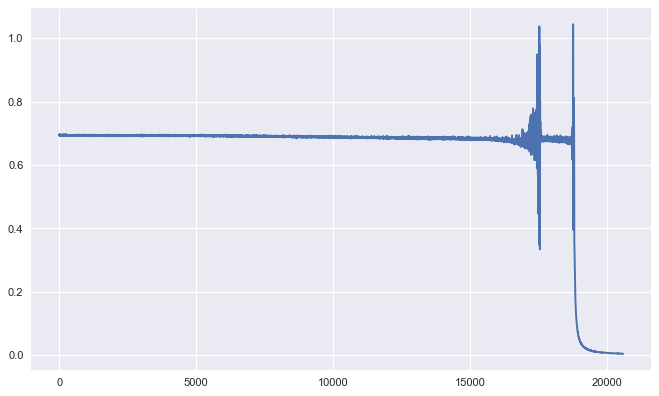

In [24]:
import seaborn as sns
sns.set()
from matplotlib.pyplot import figure

figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(losses)

# Training with variable length in [1,50]

* batch size 20
* Vanilla SGD with learning rate 1
* Binary Cross Entropy Loss



# expect to be easy, because simple model can achieve this,  hidden size 1



# visualization and animation

# curriculum learning + analyze Loss 

# finish Repo 

# OpenAI
